In [29]:
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import defaultdict

# sigmoid to shorten swish calculations!
from scipy.special import expit 

In [30]:
class Parameter:
    def __init__(self, value: float, name: str) -> None:
        self._value = value
        self._name = name
        self._grad = 0.0
        self._backward = lambda: None
        self._parameters = {id(self): self}
        self._graph = defaultdict(list)

    def __repr__(self) -> str:
        return f"Parameter {self._name} = {self._value}; dL/d[{self._name}] = {self._grad}"

    # source: https://www.geeksforgeeks.org/python-program-for-topological-sorting/
    def topologicalSortUtil(self,v,visited,stack):
        visited[v] = True
        for i in self._graph[v]:
            if visited[i] == False:
                self.topologicalSortUtil(i,visited,stack)
 
        stack.insert(0,v)
 
    def topologicalSort(self):
        visited = {p: False for p in self._parameters}
        stack =[]
        for i in self._parameters.keys():
            if visited[i] == False:
                self.topologicalSortUtil(i,visited,stack)
 
        return stack
    
    def __mul__(self, other: 'Parameter') -> 'Parameter':
        result = Parameter(
            self._value * other._value,
            f'{self._name} * {other._name}'
        )

        def _backward():
            self._grad += other._value * result._grad #dL / dself
            other._grad += self._value * result._grad # dL / dother

        result._graph.update(self._graph)
        result._graph.update(other._graph)
        result._graph[id(result)].extend([id(self), id(other)])
        result._parameters.update(self._parameters)
        result._parameters.update(other._parameters)
        result._backward = _backward

        return result

    def __add__(self, other: 'Parameter') -> 'Parameter':
        result = Parameter(
            self._value + other._value,
            f'[{self._name} + {other._name}]'
        )

        def _backward():
            self._grad += 1.0 * result._grad  #dL / dself
            other._grad += 1.0 * result._grad # dL / dother

        result._parameters.update(self._parameters)
        result._parameters.update(other._parameters)
        result._graph.update(self._graph)
        result._graph.update(other._graph)
        result._graph[id(result)].extend([id(self), id(other)])
        
        result._backward = _backward

        return result

    def backward(self):
        queue = self.topologicalSort()
        self._grad = 1
        for i in queue:
            self._parameters[i]._backward()

    def sigmoid(self) -> 'Parameter':
        # f(x) = 1 / (1 + exp(self._value))
        # f'(x) = f(x) * (1 - f(x))

        val = 1.0 / (1.0 + math.exp(-self._value))
        result = Parameter(
            val,
            f"σ({self._name})"
        )
        def _backward():
            self._grad = result._grad * val * (1 - val)

        result._backward = _backward
        return result

    def ReLU(self) -> 'Parameter':
        result = Parameter(max(0, self._value), f'ReLU({self._name})')
        
        def _backward():
            self._grad += result._grad * (self._value > 0)
            
        result._parameters.update(self._parameters)
        result._graph.update(self._graph)
        result._graph[id(result)].append(id(self))
        self._backward = _backward
        return result

    def Swish(self, b=1) -> 'Parameter':
        result = Parameter(self._value / (1 + np.exp(-b * self._value)), f'swish({self._name})')
        
        def _backward():
            self._grad += result._grad * expit(b*self._value) + self._value*b*expit(b*self._value)*(1 - expit(b*self._value))
        return result
            

def sgd(f, args: list[Parameter], steps=10, lr=1e-2, exp_decay=0.9, output=True) -> list[dict[str, float]]:
    optimized_params = {}
    
    for step in range(steps):
        result = f(*args)
        result.backward()
        
        if output:
            print(f'step {step}:')
            for param in args:
                print(param)
            
        for x in args:
            lr_t = lr * exp_decay**step
            x._value -= lr_t * x._grad
            x._grad = 0

        for x in args:
            if x._name not in optimized_params:
                optimized_params[x._name] = []
            optimized_params[x._name].append(x._value)
        
    return optimized_params

# Testing

In [31]:
def myplot(optimize_history):
    for param_name, values in optimize_history.items():
        space = np.arange(len(values))
        plt.plot(space, values, label=param_name)
    plt.title('Param optimization history')
    plt.legend()
    plt.show()

### test 1

basic test

In [32]:
x = Parameter(6, 'x')
F = lambda x : x * x + Parameter(5, '5') * x
X = sgd(F, [x], lr=0.1, exp_decay=1, steps=30)

step 0:
Parameter x = 6; dL/d[x] = 17.0
step 1:
Parameter x = 4.3; dL/d[x] = 13.600000000000001
step 2:
Parameter x = 2.9399999999999995; dL/d[x] = 10.879999999999999
step 3:
Parameter x = 1.8519999999999996; dL/d[x] = 8.703999999999999
step 4:
Parameter x = 0.9815999999999997; dL/d[x] = 6.963199999999999
step 5:
Parameter x = 0.28527999999999976; dL/d[x] = 5.57056
step 6:
Parameter x = -0.27177600000000035; dL/d[x] = 4.456448
step 7:
Parameter x = -0.7174208000000004; dL/d[x] = 3.5651583999999996
step 8:
Parameter x = -1.0739366400000003; dL/d[x] = 2.8521267199999993
step 9:
Parameter x = -1.3591493120000002; dL/d[x] = 2.281701375999999
step 10:
Parameter x = -1.5873194496000003; dL/d[x] = 1.8253611007999995
step 11:
Parameter x = -1.7698555596800003; dL/d[x] = 1.4602888806399994
step 12:
Parameter x = -1.9158844477440002; dL/d[x] = 1.1682311045119995
step 13:
Parameter x = -2.0327075581952; dL/d[x] = 0.9345848836095998
step 14:
Parameter x = -2.1261660465561603; dL/d[x] = 0.747667906

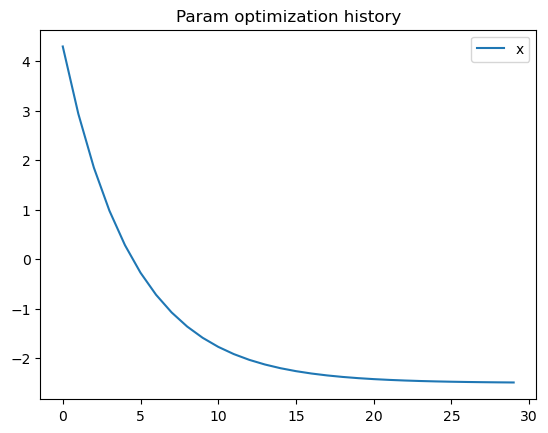

In [33]:
myplot(X)

### test 2

test with multivariable function

In [34]:
x1 = Parameter(5, 'x1')
x2 = Parameter(2, 'x2')
x3 = Parameter(5, 'x3')
def F(x1,x2,x3):
    return x1*x1 + x2*x2 + x3*x3 + x1*x2 + Parameter(10, 'a')
opt = sgd(F, [x1,x2,x3], steps=400,lr=0.01,exp_decay=1.,output=False) 

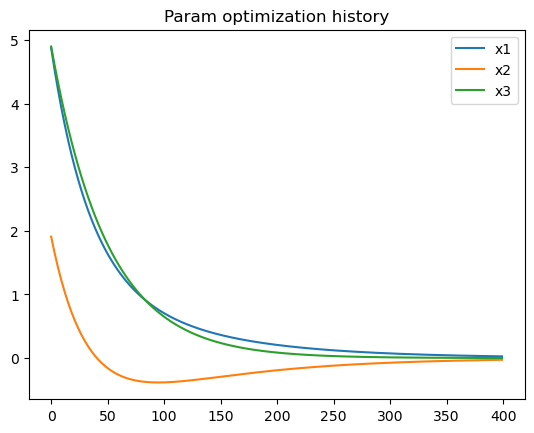

In [35]:
myplot(opt)

### test 3

Test with bigger $lr$ and decay.

step 0:
Parameter x1 = 5; dL/d[x1] = 12.0
Parameter x2 = 2; dL/d[x2] = 9.0
Parameter x3 = 10; dL/d[x3] = 20.0
step 1:
Parameter x1 = -19.0; dL/d[x1] = -54.0
Parameter x2 = -16.0; dL/d[x2] = -51.0
Parameter x3 = -30.0; dL/d[x3] = -60.0
step 2:
Parameter x1 = 67.4; dL/d[x1] = 200.4
Parameter x2 = 65.60000000000001; dL/d[x2] = 198.60000000000002
Parameter x3 = 66.0; dL/d[x3] = 132.0
step 3:
Parameter x1 = -189.11200000000005; dL/d[x1] = -566.8320000000002
Parameter x2 = -188.60800000000006; dL/d[x2] = -566.3280000000002
Parameter x3 = -102.96000000000004; dL/d[x3] = -205.92000000000007
step 4:
Parameter x1 = 391.32396800000026; dL/d[x1] = 1173.959808000001
Parameter x2 = 391.31187200000033; dL/d[x2] = 1173.947712000001
Parameter x3 = 107.9020800000001; dL/d[x3] = 215.8041600000002
step 5:
Parameter x1 = -570.3839067136007; dL/d[x1] = -1711.153907097602
Parameter x2 = -570.3860936704007; dL/d[x2] = -1711.156094054402
Parameter x3 = -68.88468787200009; dL/d[x3] = -137.76937574400017
step 6:

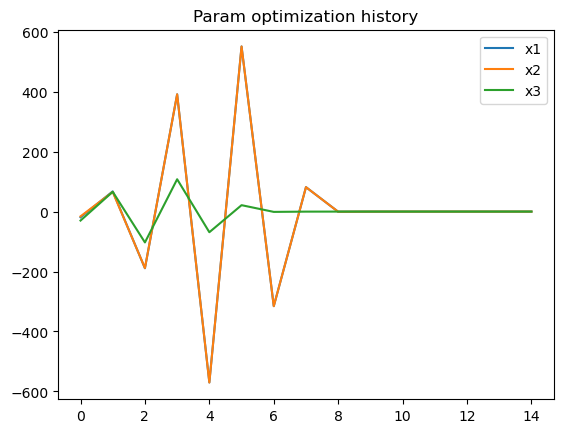

In [36]:
x1 = Parameter(5, 'x1')
x2 = Parameter(2, 'x2')
x3 = Parameter(10, 'x3')
def F(x1,x2,x3):
    return x1*x1 + x2*x2 + x3*x3 + x1*x2 + Parameter(10, 'a')
myplot(sgd(F, [x1,x2,x3],steps=15,lr=2.,exp_decay=.8, output=True))

### test 3

test with swish

In [37]:
x = Parameter(6, 'x')
F = lambda x : x * x + x.Swish()
X = sgd(F, [x], lr=0.1, exp_decay=1, steps=30, output=False)

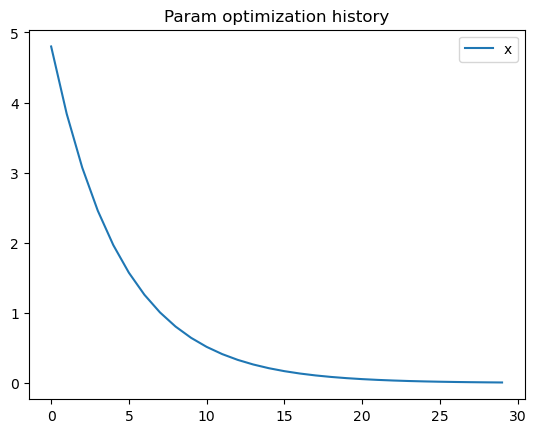

In [38]:
myplot(X)